In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import scipy as sp
import scipy.stats as stats
from scipy.interpolate import interp1d

import stats13tools.stats13tools as st

%matplotlib inline

In [2]:
colors = {"orange": "#f0ad4e",
          "red": "#d9534f",
          "blue": "#5bc0de",
          "green": "#5cb85c",
          "gray": "#636c72",
          "lightgray": "#d2d2d2"
         }

# The Gilbert's case

## Shifts data

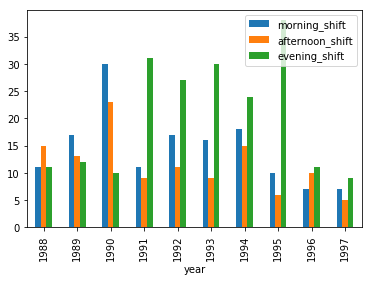

In [3]:
shifts = pd.read_csv("data-src/gilbert-data.csv")
shifts.index = shifts.year
shifts[shifts.columns[1:]].plot(kind="bar");

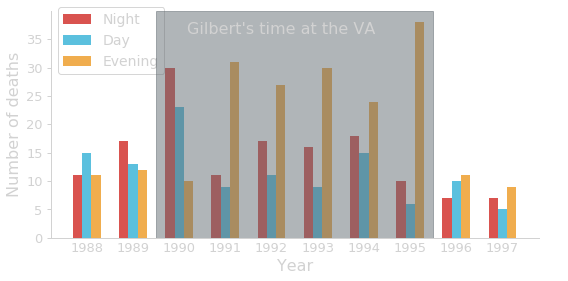

In [193]:
fig,ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

width=0.6
scale = 3.

colors_list = ["red", "blue", "orange"]
labels_list = ["Night", "Day", "Evening"]
xpos = np.arange(len(shifts.year))*scale

for i,shift in enumerate(shifts.columns[1:]):
    ax1.bar(xpos+width*i, shifts[shift], width=width, color=colors[colors_list[i]], label=labels_list[i]);
    
for spine in ["bottom", "left"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(colors["lightgray"])
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_xticks(xpos+width)
    ax.set_xticklabels(shifts.year)
    ax.set_ylim(0)
    ax.tick_params(axis="y", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.tick_params(axis="x", size=0, labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Year", size=16, color=colors["lightgray"])
    ax.set_ylabel("Number of deaths", size=16, color=colors["lightgray"])
    legend = ax.legend(prop=dict(size=14), loc="upper left", frameon=True, facecolor="none",
                      bbox_to_anchor=(0, 1.05))
    for text in legend.get_texts():
        text.set_color(colors["lightgray"])
        
for ax in [ax2]:
    ax2.axis("off")
    ax.axvspan(xpos[2]-1.5*width, xpos[8]-1.5*width, alpha=0.5, color=colors["gray"])
    ax.text(xpos[2]-1.5*width+(xpos[8]-1.5*width-xpos[2]-1.5*width)/2, 
            ax.get_ylim()[1]*0.9, "Gilbert's time at the VA", color=colors["lightgray"], 
           ha="center", size=16)
    
plt.tight_layout()
    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/gilbert-case-shifts-pattern.svg", transparent=True)

## Relative risk

In [4]:
data = pd.DataFrame({"shift_gilbert": [40, 217],
                     "shift_no_gilbert": [34, 1350]}, index=["death", "no_death"])
data

,shift_gilbert,shift_no_gilbert
death,40,34
no_death,217,1350


In [5]:
data.shift_gilbert/data.shift_gilbert.sum()

death       0.155642
no_death    0.844358
Name: shift_gilbert, dtype: float64

In [6]:
data.shift_no_gilbert/data.shift_no_gilbert.sum()

death       0.024566
no_death    0.975434
Name: shift_no_gilbert, dtype: float64

In [58]:
rr = (data.shift_gilbert/data.shift_gilbert.sum()).death/(data.shift_no_gilbert/data.shift_no_gilbert.sum()).death
print("Relative risk: {:.5f}".format(rr))

Relative risk: 6.33555


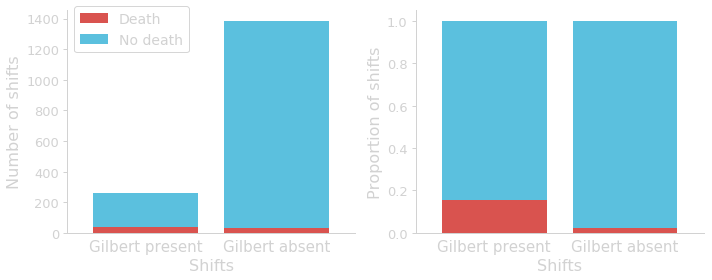

In [8]:
fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))


ax1.bar(np.arange(2), data.ix["death"], color=colors['red'], label="Death");
ax1.bar(np.arange(2), data.ix["no_death"], bottom=data.ix["death"], color=colors['blue'], label="No death");

ax2.bar(np.arange(2), data.ix["death"]/data.sum(), color=colors['red']);
ax2.bar(np.arange(2), data.ix["no_death"]/data.sum(), bottom=data.ix["death"]/data.sum(), color=colors['blue']);


for ax in [ax1, ax2]:
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels(["Gilbert present", "Gilbert absent"])
    ax.set_ylim(0)
    ax.tick_params(axis="y", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.tick_params(axis="x", size=0, labelcolor=colors["lightgray"], 
                   labelsize=15, pad=6)
    ax.set_xlim(-0.6, 1.6)
    ax.set_xlabel("Shifts", size=16, color=colors["lightgray"])
    
for ax in [ax1]:
    ax.set_ylabel("Number of shifts", size=16, color=colors["lightgray"])
    legend = ax.legend(prop=dict(size=14), loc="upper left", frameon=True, facecolor="none",
                      bbox_to_anchor=(0, 1.05))
    for text in legend.get_texts():
        text.set_color(colors["lightgray"])

for ax in [ax2]:
    ax.set_ylabel("Proportion of shifts", size=16, color=colors["lightgray"])

        
plt.tight_layout()

    
plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/gilbert-case-death-pattern-during-shifts.svg", transparent=True)

# Null hypothesis testing (Shuffling)

In [9]:
data

,shift_gilbert,shift_no_gilbert
death,40,34
no_death,217,1350


In [10]:
print("Total number of shifts: {}".format(data.values.sum()))
print("Proportion of shifts for which death occured: {}".format(data.ix["death"].sum()/data.values.sum()))

Total number of shifts: 1641
Proportion of shifts for which death occured: 0.04509445460085314


#### If death was equally likely to happen during the shifts with and without Gilbert present, then the proportion of shifts with death should be the same for both conditions

In [15]:
#the population is all the shifts, with as many 1 as shift with death
all_shifts = np.zeros(data.values.sum())
all_shifts[:data.ix["no_death"].sum()]=1

#initial observed statistic (difference in relative proportions)
diff_init = data.ix["death"].shift_gilbert/data.shift_gilbert.sum()-data.ix["death"].shift_no_gilbert/data.shift_no_gilbert.sum()

In [12]:
n_simul = 10000
res_diff = np.zeros(n_simul) #store the data
res_relativerisk = np.zeros(n_simul) #store the data
n_shift_gilbert = data.shift_gilbert.sum() #number of shifts with Gilbert present
n_shift_no_gilbert = data.shift_no_gilbert.sum() #number of shifts without Gilbert present

#each simulation is the shuffling of the full population and the
#calculation of the difference in proportion of shifts with death
for i in range(n_simul):
    np.random.shuffle(all_shifts)
    with_gilbert = all_shifts[:n_shift_gilbert]
    without_gilbert = all_shifts[n_shift_gilbert:]
    deathprop_with_gilbert = np.sum(with_gilbert)/n_shift_gilbert
    deathprop_without_gilbert = np.sum(without_gilbert)/n_shift_no_gilbert
    difference = deathprop_with_gilbert-deathprop_without_gilbert
    relativerisk = deathprop_with_gilbert/deathprop_without_gilbert
    res_diff[i] = difference
    res_relativerisk[i] = relativerisk

In [38]:
data.shift_gilbert.sum()

257

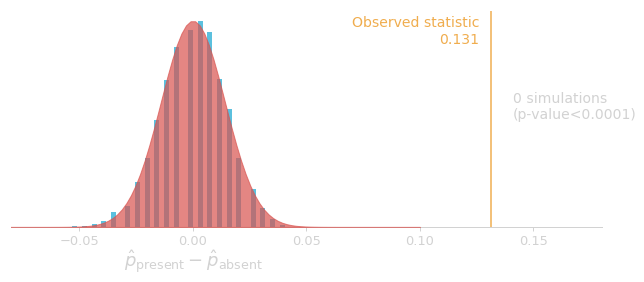

In [44]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_diff, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.text(0, -250, '$\hat{p}_{\mathrm{present}}-\hat{p}_{\mathrm{absent}}$', size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    ax.set_xlim(-0.08, 0.18)
    
for ax in [ax2]:
    ax.axvline(diff_init, color=colors["orange"])
    ax.text(diff_init-0.005, ax.get_ylim()[1]*0.85, "Observed statistic\n{:.3f}".format(diff_init), size=14, color=colors["orange"], ha="right")

for ax in [ax3]:
    ax.text(diff_init+0.01, ax.get_ylim()[1]*0.5, "{:.0f} simulations\n(p-value<0.0001)".format(np.sum(res_diff>diff_init)), size=14, color=colors["lightgray"], ha="left")
    
    
for ax in [ax4]:
    ax.axis("off")
    #normal
    norm_mu = 0
    pooled_p = data.ix["death"].sum()/data.values.sum()
    p1 = (data.shift_gilbert/data.shift_gilbert.sum()).death
    p2 = (data.shift_no_gilbert/data.shift_no_gilbert.sum()).death
    norm_sigma = np.sqrt((pooled_p*(1-pooled_p))*(1/data.shift_gilbert.sum()+1/data.shift_no_gilbert.sum()))
    x = np.linspace(-0.1,0.1,100)
    ynorm = stats.norm.pdf(x, norm_mu, norm_sigma)
    ax.fill_between(x, ynorm, color=colors["red"], alpha=0.7)
    ax.set_ylim(0)


    
    
for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/gilbert-case-resampling-differences.svg", transparent=True)

In [36]:
data

,shift_gilbert,shift_no_gilbert
death,40,34
no_death,217,1350


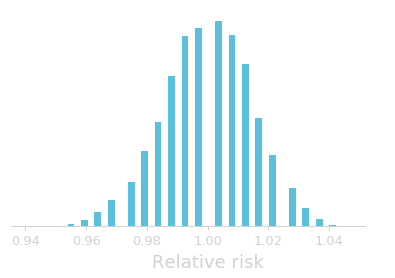

In [253]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_relativerisk, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.text(1, -250, 'Relative risk', size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    #ax.set_xlim(0.85, 7)
    
#for ax in [ax2]:
#    ax.axvline(rr, color=colors["orange"])

for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")

#plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/salaries-ucla2014-resampling-ttest.svg", transparent=True)

## Z test

In [48]:
z = ((40/257)-(34/1384))/np.sqrt((74/1641)*(1-74/1641)*(1/257+1/1384))
z

9.2995134253998479

# Confidence intervals of RR

In [51]:
#we keep the two groups separated and draw bootstrap samples from them
population_gilbert = np.zeros(data.shift_gilbert.sum())
population_gilbert[:data.shift_gilbert.death] = 1
population_no_gilbert = np.zeros(data.shift_no_gilbert.sum())
population_no_gilbert[:data.shift_no_gilbert.death] = 1

n_simul = 10000
res_diff = np.zeros(n_simul) #store the data
res_relativerisk = np.zeros(n_simul) #store the data
n_shift_gilbert = data.shift_gilbert.sum() #number of shifts with Gilbert present
n_shift_no_gilbert = data.shift_no_gilbert.sum() #number of shifts without Gilbert present

#each simulation is the separate bootstrap drawing from the two groups
#calculation of the statistic
for i in range(n_simul):
    sample_gilbert = np.random.choice(population_gilbert, size=n_shift_gilbert)
    sample_no_gilbert = np.random.choice(population_no_gilbert, size=n_shift_no_gilbert)
    deathprop_with_gilbert = np.sum(sample_gilbert)/n_shift_gilbert
    deathprop_without_gilbert = np.sum(sample_no_gilbert)/n_shift_no_gilbert
    difference = deathprop_with_gilbert-deathprop_without_gilbert
    relativerisk = deathprop_with_gilbert/deathprop_without_gilbert
    res_diff[i] = difference
    res_relativerisk[i] = relativerisk

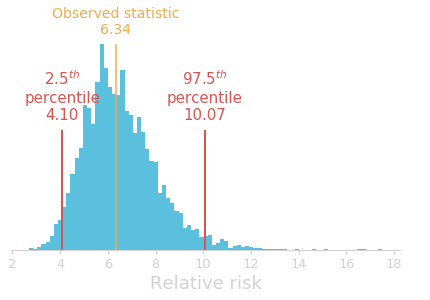

In [69]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.03, 0.15, 0.9, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_relativerisk, bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Relative risk", size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    #ax.set_xlim(0.85, 7)
    
for ax in [ax2]:
    ax.axvline(rr, color=colors["orange"], ymax=0.95)
    ax.text(rr, ax.get_ylim()[1]*1, "Observed statistic\n{:.2f}".format(rr), size=14, color=colors["orange"], ha="center")

for ax in [ax3]:
    ax.axvline(np.percentile(res_relativerisk, 2.5), ymax=0.55, color=colors["red"], lw=2)
    ax.axvline(np.percentile(res_relativerisk, 97.5), ymax=0.55, color=colors["red"], lw=2)
    ax.text(np.percentile(res_relativerisk, 2.5), ax.get_ylim()[1]*0.6, "2.5$^{{th}}$\npercentile\n{:.2f}".format(np.percentile(res_relativerisk, 2.5)), color=colors["red"], size=15, ha="center")
    ax.text(np.percentile(res_relativerisk, 97.5), ax.get_ylim()[1]*0.6, "97.5$^{{th}}$\npercentile\n{:.2f}".format(np.percentile(res_relativerisk, 97.5)), color=colors["red"], size=15, ha="center")


for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/gilbert-case-resampling-relativerisk-ci95.svg", transparent=True)

# Oklahoma City Thunder (NBA team)

In [3]:
data = pd.DataFrame({"sellout": [3, 15],
                     "no_sellout": [12, 11]}, index=["win", "loss"])
data

,no_sellout,sellout
win,12,3
loss,11,15


In [7]:
data_r = data/data.sum()
data_r

,no_sellout,sellout
win,0.521739,0.166667
loss,0.478261,0.833333


In [84]:
relativerisk = data_r.no_sellout.win/data_r.sellout.win #3.13 times more likely to win if no sell out
all_games = np.zeros(data.values.sum())
all_games[:data.ix["win"].sum()]=1

n_simul = 10000
res_relativerisk = np.zeros(n_simul) #store the data
n_sellout = data.sellout.sum() #number of sell out crowd games
n_no_sellout = data.no_sellout.sum() #number of no sell out crowd games

#each simulation is the shuffling of the full population and the
#calculation of the relative risk in proportion of no sell out crowd games
for i in range(n_simul):
    np.random.shuffle(all_games)
    sellout = all_games[:n_sellout]
    no_sellout = all_games[n_sellout:]
    res_relativerisk[i] = (np.sum(no_sellout)/len(no_sellout))/(np.sum(sellout)/len(sellout))

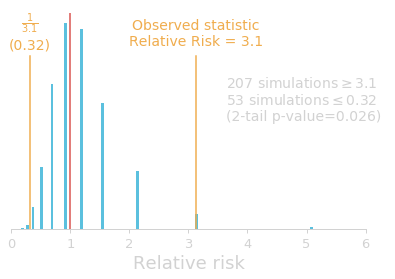

In [86]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.1, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_relativerisk[res_relativerisk!=np.inf], bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    #ax.text(1, -250, 'Relative risk', size=18, color=colors["lightgray"], ha="center")
    ax.set_xlabel('Relative risk', size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    ax.set_xlim(0., 6)
    ax.axvline(1, color=colors["red"], ymax=1)
    
for ax in [ax2]:
    ax.axvline(relativerisk, color=colors["orange"], ymax=0.8)
    ax.text(relativerisk, ax.get_ylim()[1]*0.85, "Observed statistic\nRelative Risk = {:.1f}".format(relativerisk), size=14, color=colors["orange"], ha="center")

for ax in [ax3]:
    ax.text(relativerisk+0.5, ax.get_ylim()[1]*0.5, "{:.0f} simulations$\geq${:.1f}\n{:.0f} simulations$\leq${:.2f}\n(2-tail p-value={:.3f})".format(np.sum(res_relativerisk>=relativerisk), relativerisk, np.sum(res_relativerisk<=1/relativerisk), 1/relativerisk, (np.sum(res_relativerisk>=relativerisk)+np.sum(res_relativerisk<=1/relativerisk))/10000), size=14, color=colors["lightgray"], ha="left")
    ax.axvline(1/relativerisk, color=colors["orange"], ymax=0.8)
    ax.text(1/relativerisk, ax.get_ylim()[1]*0.85, r"$\frac{{1}}{{3.1}}$" "\n({:.2f})".format(1/relativerisk), size=14, color=colors["orange"], ha="center")


for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")

plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/sell-out-crowd-simulation-pvalue.svg", transparent=True)

### 95% confidence intervals

In [87]:
#we keep the two groups separated and draw bootstrap samples from them
population_sellout = np.zeros(data.sellout.sum())
population_sellout[:data.sellout.win] = 1
population_no_sellout = np.zeros(data.no_sellout.sum())
population_no_sellout[:data.no_sellout.win] = 1


n_simul = 10000
res_relativerisk = np.zeros(n_simul) #store the data
n_sellout = data.sellout.sum() #number of shifts with Gilbert present
n_no_sellout = data.no_sellout.sum() #number of shifts without Gilbert present

#each simulation is the separate bootstrap drawing from the two groups
#calculation of the statistic
for i in range(n_simul):
    sample_sellout = np.random.choice(population_sellout, size=n_sellout)
    sample_no_sellout = np.random.choice(population_no_sellout, size=n_no_sellout)
    relativerisk = (sample_no_sellout.sum()/n_no_sellout)/(sample_sellout.sum()/n_sellout)
    res_relativerisk[i] = relativerisk

/Users/Gui/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars


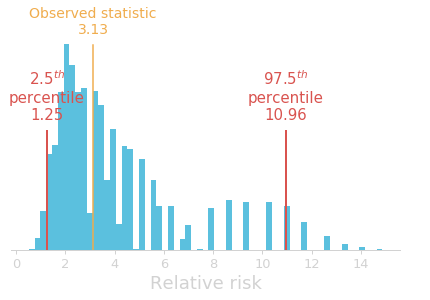

In [100]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.03, 0.15, 0.9, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
for ax in [ax1]:
    ax.hist(res_relativerisk[res_relativerisk!=np.inf], bins="auto", color=colors["blue"])
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(colors["lightgray"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=colors["lightgray"], labelcolor=colors["lightgray"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Relative risk", size=18, color=colors["lightgray"], ha="center")
    ax.set_ylim(0)
    #ax.set_xlim(0.85, 7)
    
for ax in [ax2]:
    ax.axvline(data_r.no_sellout.win/data_r.sellout.win, color=colors["orange"], ymax=0.95)
    ax.text(data_r.no_sellout.win/data_r.sellout.win, ax.get_ylim()[1]*1, "Observed statistic\n{:.2f}".format(data_r.no_sellout.win/data_r.sellout.win), size=14, color=colors["orange"], ha="center")

for ax in [ax3]:
    ax.axvline(np.percentile(res_relativerisk[res_relativerisk!=np.inf], 2.5), ymax=0.55, color=colors["red"], lw=2)
    ax.axvline(np.percentile(res_relativerisk[res_relativerisk!=np.inf], 97.5), ymax=0.55, color=colors["red"], lw=2)
    ax.text(np.percentile(res_relativerisk[res_relativerisk!=np.inf], 2.5), ax.get_ylim()[1]*0.6, "2.5$^{{th}}$\npercentile\n{:.2f}".format(np.percentile(res_relativerisk[res_relativerisk!=np.inf], 2.5)), color=colors["red"], size=15, ha="center")
    ax.text(np.percentile(res_relativerisk[res_relativerisk!=np.inf], 97.5), ax.get_ylim()[1]*0.6, "97.5$^{{th}}$\npercentile\n{:.2f}".format(np.percentile(res_relativerisk[res_relativerisk!=np.inf], 97.5)), color=colors["red"], size=15, ha="center")


for ax in [ax2, ax3]:
    ax.set_ylim(0)
    ax.axis("off")


plt.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/sell-out-crowd-simulation-ci95.svg", transparent=True)

In [96]:
np.percentile(res_relativerisk, 97.5)

inf